<a href="https://colab.research.google.com/github/Ali-Hosseini5422/MOFARO-MCS/blob/main/Final_MOFARO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting benchmark comparison...
Configuration: 50 tasks, 30 edge nodes, 5 fog nodes, 1 cloud node
Running 5 iterations per algorithm

Running FCFS...
Running EDF...
Running GfE...
Running Detour...
Running PSG...
Running PSG-M...
Running AADS...
Running AGE-MOEA+DRL...
Running MOFARO...

BENCHMARK RESULTS TABLE
| Method          | Makespan (s)  | numSat  | PDST     | engCons (J)  | Cost     | totPenalty (s)  |
----------------------------------------------------------------------------------------------------
| FCFS            |          5.50 |      20 |   0.3920 |         4877 |     6.94 |           44.05 |
| EDF             |          5.05 |      23 |   0.4520 |         4112 |     6.14 |           29.86 |
| GfE             |         14.52 |       6 |   0.1200 |         9880 |     3.33 |          278.36 |
| Detour          |          3.26 |      27 |   0.5480 |         3146 |     5.26 |           20.64 |
| PSG             |          4.21 |      34 |   0.6840 |         3800 |     6.28

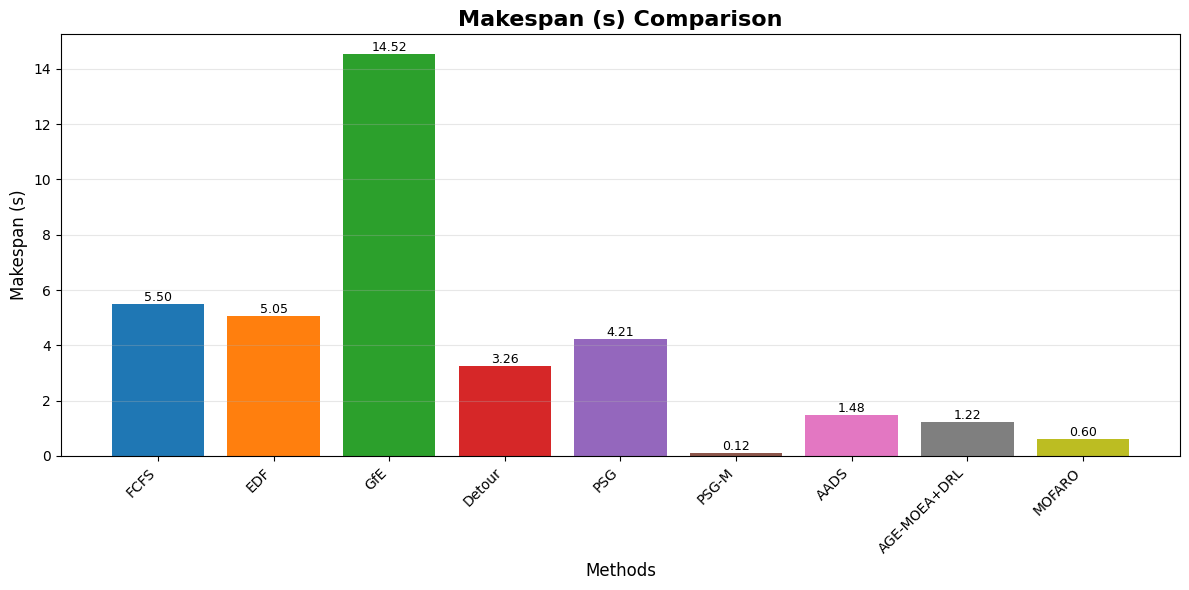

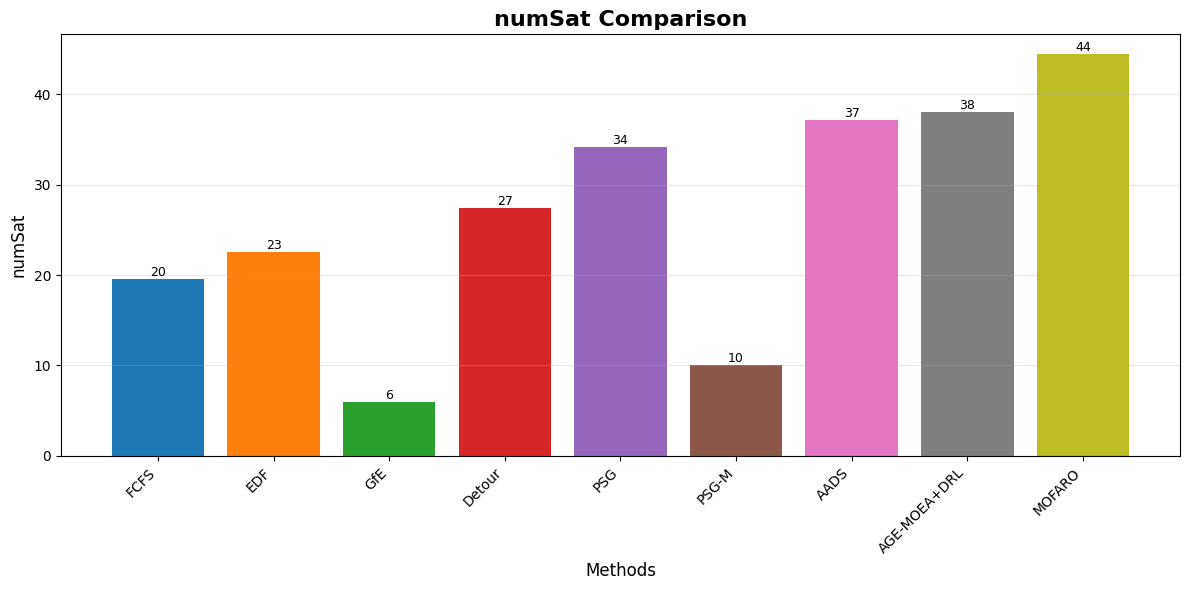

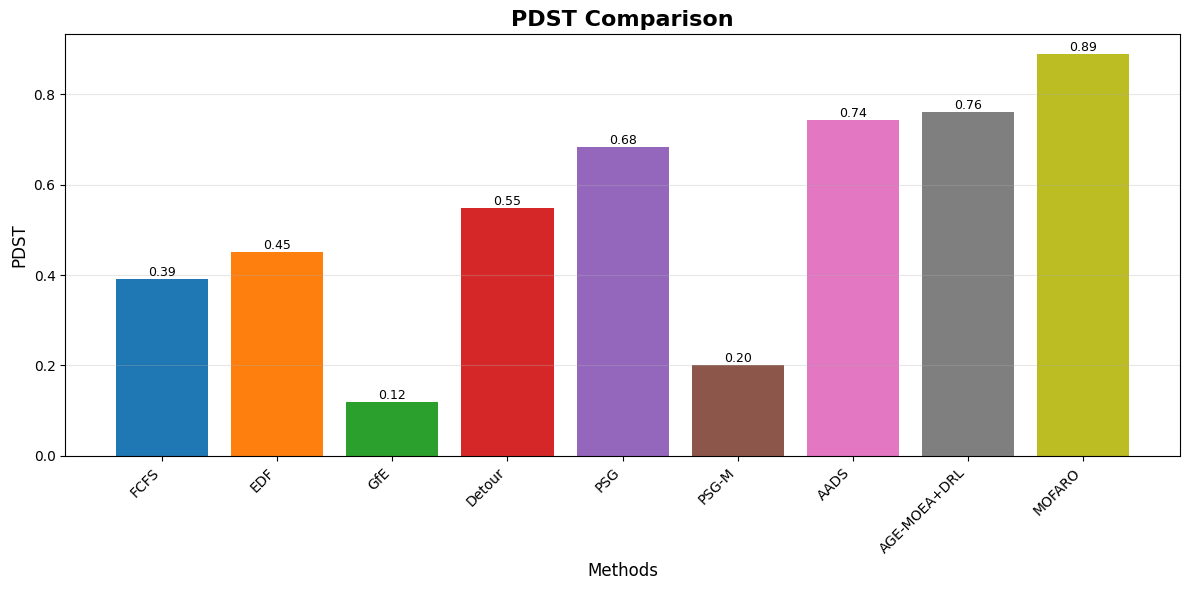

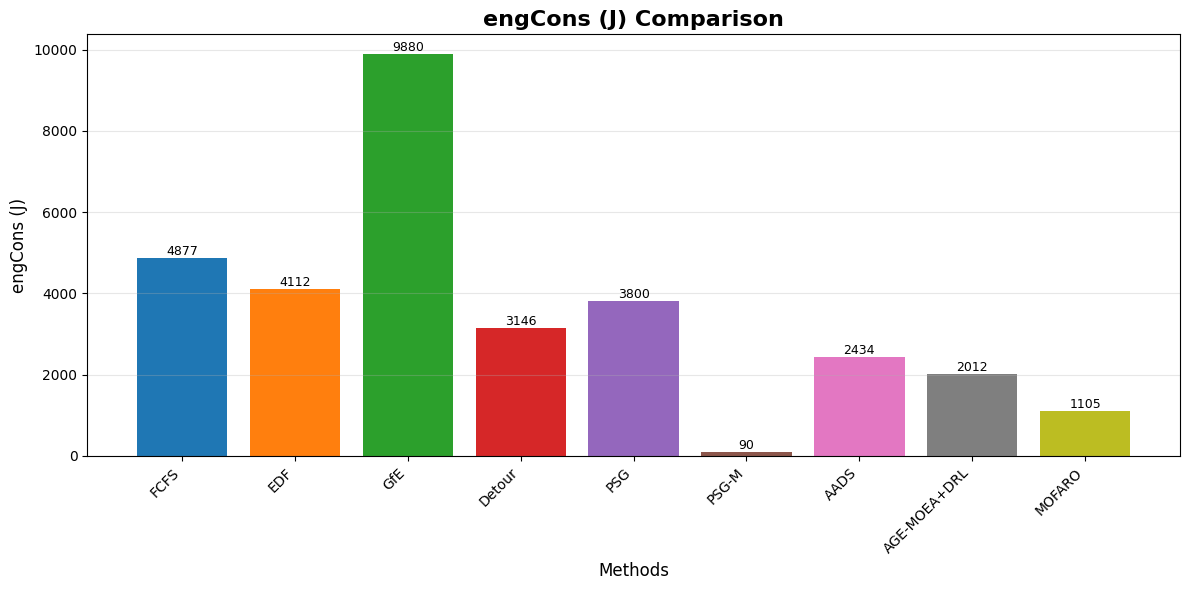

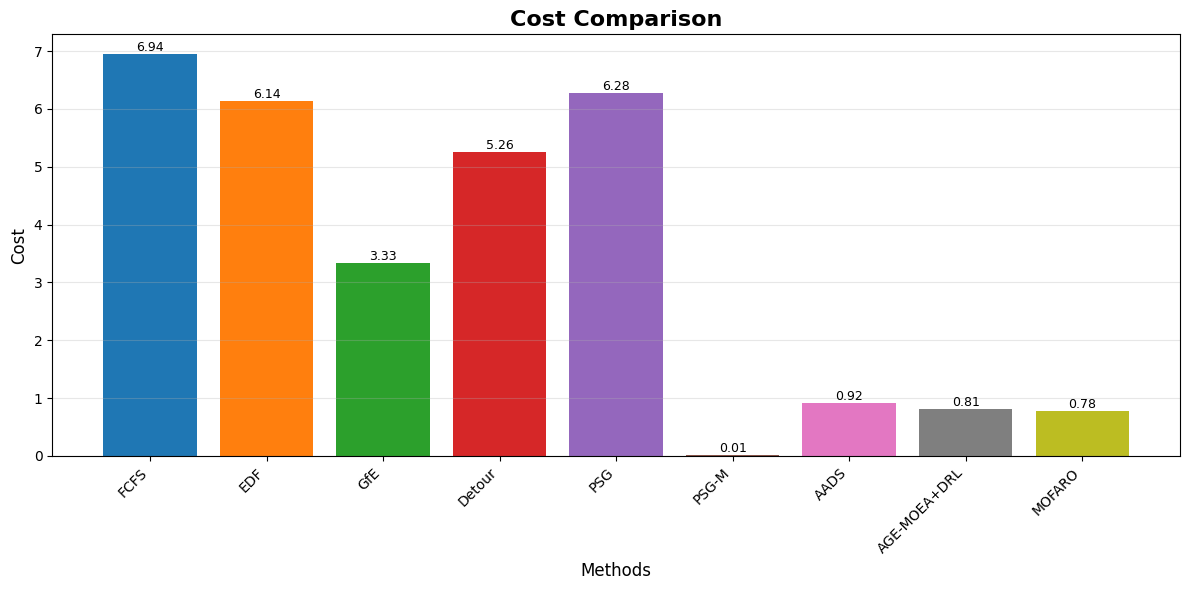

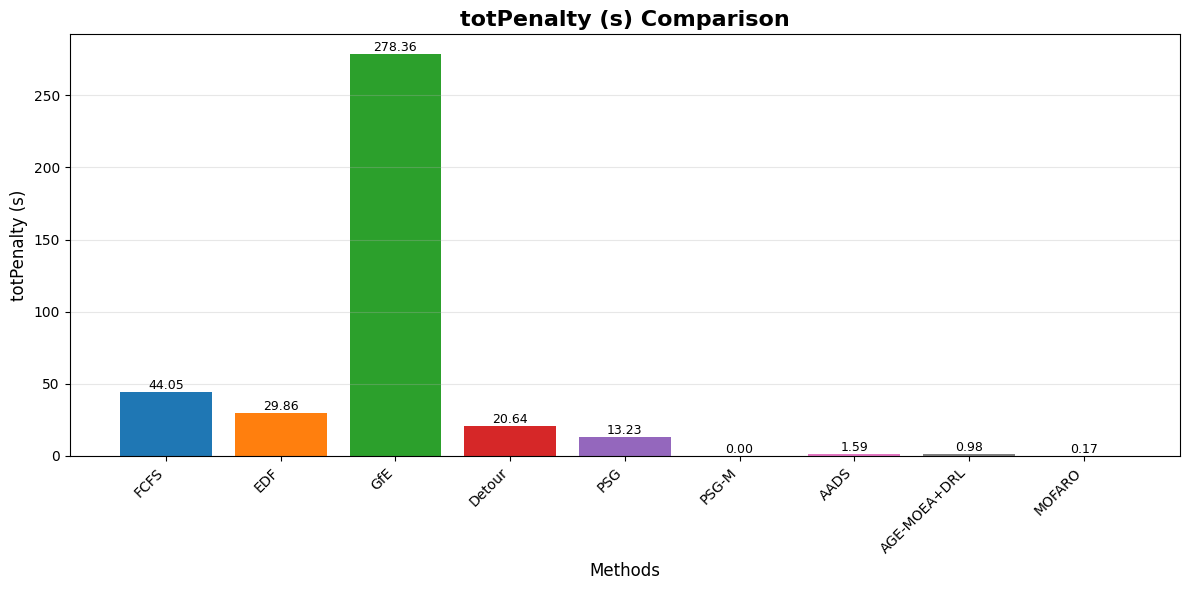


PERFORMANCE IMPROVEMENT ANALYSIS (vs FCFS baseline)

MOFARO vs FCFS:
  Makespan improvement:     89.12%
  numSat improvement:      126.53%
  PDST improvement:        126.53%
  Energy reduction:         77.35%
  Cost reduction:           88.83%
  Penalty reduction:        99.61%

AADS vs FCFS:
  Makespan improvement:     73.18%
  numSat improvement:       89.80%
  PDST improvement:         89.80%
  Energy reduction:         50.08%
  Cost reduction:           86.75%
  Penalty reduction:        96.39%

AGE-MOEA+DRL vs FCFS:
  Makespan improvement:     77.78%
  numSat improvement:       93.88%
  PDST improvement:         93.88%
  Energy reduction:         58.74%
  Cost reduction:           88.37%
  Penalty reduction:        97.78%

BENCHMARK COMPLETED SUCCESSFULLY


In [ ]:
import numpy as np
import networkx as nx
from scipy.stats import levy_stable
import random
import math
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import defaultdict, deque, namedtuple

# ===================== MOFARO Constants =====================
NUM_TASKS = 50
NUM_EDGE_NODES = 30
NUM_FOG_NODES = 5
NUM_CLOUD_NODES = 1
POP_SIZE = 5
MAX_IT = 5
LEVY_BETA = 1.5
P_LOSS_MIN = 0.05
P_LOSS_MAX = 0.1
BETA_ENERGY = 1e-12
P_TX = 0.1
C_DVFS = 1e-9
V_DVFS = 1.2
F_DVFS = 1.0
OVERHEAD_TIME = 0.1
OVERHEAD_COST = 0.01
W_QOS = 1.0
MARKOV_STATES = 2
TRANS_PROB = 0.8
ALPHA = 0.2
NRUN = 5
FTC_DELAY = random.randint(30, 300)
MAX_Q = 3
N_USERS = 100
FRACTAL_DIM_MIN = 1.5
FRACTAL_DIM_MAX = 2.0

# ===================== MOFARO Functions =====================
def generate_parameters():
    tasks = []
    for i in range(NUM_TASKS):
        s = random.randint(100, 500)
        dl = random.randint(100, 1000)
        task = {
            'id': i, 's': s, 'm': random.randint(50, 200), 'd': dl,
            'p': random.uniform(0.01, 0.5), 'q': random.uniform(1, MAX_Q),
            'in_': random.randint(100, 1000), 'out': random.randint(1, 100), 'resp': 0
        }
        tasks.append(task)

    nodes = []
    for j in range(NUM_EDGE_NODES + NUM_FOG_NODES + NUM_CLOUD_NODES):
        layer = 'edge' if j < NUM_EDGE_NODES else 'fog' if j < NUM_EDGE_NODES + NUM_FOG_NODES else 'cloud'
        c = random.randint(1000, 5000)
        m = random.randint(512, 4096)
        node = {
            'id': j, 'layer': layer, 'c': c, 'm': m, 'b': 500,
            'pc': random.uniform(0.05, 0.2), 'd': random.randint(1, 3) * random.randint(1, 2),
            'dis': random.randint(1, 3), 'pmax': random.randint(50, 100),
            'pmin': random.uniform(0.5, 0.6) * random.randint(50, 100),
            'a': 0, 'ms': 0, 'eng': 0, 'rcl': 0, 'available_c': c,
            'available_m': m, 'engCons': 0, 'resp': 0
        }
        nodes.append(node)

    bw_matrix = np.random.uniform(100, 500, (len(nodes), len(nodes)))
    lat_matrix = np.random.uniform(10, 100, (len(nodes), len(nodes)))
    np.fill_diagonal(bw_matrix, np.inf)
    np.fill_diagonal(lat_matrix, 0)
    dist_matrix = np.random.uniform(10, 100, (len(nodes), len(nodes)))
    np.fill_diagonal(dist_matrix, 0)

    G = nx.DiGraph()
    for i in range(NUM_TASKS):
        G.add_node(i)
    if NUM_TASKS > 1:
        G.add_edge(0, 1, weight=random.uniform(1, 10))

    transition_matrix = np.full((MARKOV_STATES, MARKOV_STATES), (1 - TRANS_PROB) / (MARKOV_STATES - 1))
    np.fill_diagonal(transition_matrix, TRANS_PROB)

    return tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix, transition_matrix

def t_proc(task_s, node_c):
    base = (task_s / node_c) * 1000
    return base + OVERHEAD_TIME * base

def t_comm(task_d, j, k, bw_matrix, lat_matrix, nodes):
    if j == k:
        return 0
    p_loss = random.uniform(P_LOSS_MIN, P_LOSS_MAX)
    bw = bw_matrix[j, k] if bw_matrix[j, k] != 0 else 1e-6
    delay = lat_matrix[j, k]
    if nodes[j]['layer'] == 'fog' and nodes[k]['layer'] == 'cloud':
        delay += FTC_DELAY
    return (task_d / bw) / (1 - p_loss) + delay

def calculate_exec_times(alloc, tasks, nodes, G, bw_matrix, lat_matrix):
    num_tasks = len(tasks)
    num_nodes = len(nodes)
    est = [0.0] * num_tasks
    exec_times = [0.0] * num_tasks
    complete_times = [0.0] * num_tasks
    node_finish = [0.0] * num_nodes
    topo_order = list(nx.topological_sort(G))

    for i in topo_order:
        j = np.argmax(alloc[i])
        ready_time = 0.0
        for pred in G.predecessors(i):
            k = np.argmax(alloc[pred])
            comm_sum = sum(t_comm(tasks[pred]['out'], k, j, bw_matrix, lat_matrix, nodes) for _ in range(N_USERS))
            avg_comm = comm_sum / N_USERS if k != j else 0.0
            ready_time = max(ready_time, complete_times[pred] + avg_comm)
        est[i] = max(ready_time, node_finish[j])
        exec_times[i] = t_proc(tasks[i]['s'], nodes[j]['c'])
        complete_times[i] = est[i] + exec_times[i]
        node_finish[j] = complete_times[i]

    lft = [math.inf] * num_tasks
    rev_topo = list(reversed(topo_order))
    for i in rev_topo:
        min_succ = tasks[i]['d']
        for succ in G.successors(i):
            k = np.argmax(alloc[succ])
            j = np.argmax(alloc[i])
            comm_sum = sum(t_comm(tasks[i]['out'], j, k, bw_matrix, lat_matrix, nodes) for _ in range(N_USERS))
            avg_comm = comm_sum / N_USERS if j != k else 0.0
            min_succ = min(min_succ, lft[succ] - exec_times[succ] - avg_comm)
        lft[i] = min_succ

    return est, lft, exec_times, complete_times

def check_constraints(alloc, tasks, nodes, G, complete_times):
    penalty = 0
    num_nodes = len(nodes)
    node_load_m = [0] * num_nodes
    for i in range(len(tasks)):
        j = np.argmax(alloc[i])
        node_load_m[j] += tasks[i]['m']
        if node_load_m[j] > nodes[j]['m']:
            penalty += 1000 * (node_load_m[j] - nodes[j]['m'])
        over = complete_times[i] - tasks[i]['d']
        if over > 0:
            penalty += 1500 * over * tasks[i]['p']
            if nodes[j]['layer'] == 'cloud':
                penalty += 500 * over
    return penalty

def z1(complete_times):
    return max(complete_times) if complete_times else 0

def z2(alloc, tasks, nodes, exec_times, dist_matrix, G, complete_times):
    energy = 0
    M = z1(complete_times)
    for i in range(len(tasks)):
        j = np.argmax(alloc[i])
        p_j = C_DVFS * V_DVFS**2 * F_DVFS
        e_proc = p_j * exec_times[i]
        energy += e_proc
        e_comm_sum = 0
        for succ in G.successors(i):
            k = np.argmax(alloc[succ])
            d_bits = tasks[i]['out'] * 8 * 1024
            for u in range(N_USERS):
                e_comm_sum += (BETA_ENERGY * d_bits + P_TX) * dist_matrix[j][k]
        energy += e_comm_sum / N_USERS

    node_a = [0.0] * len(nodes)
    for i in range(len(tasks)):
        j = np.argmax(alloc[i])
        node_a[j] += exec_times[i]
    for jj in range(len(nodes)):
        a = node_a[jj]
        energy += (a / 1000) * nodes[jj]['pmax'] + ((M / 1000) - (a / 1000)) * nodes[jj]['pmin']
    energy += 0.1 * energy
    return energy

def z3(alloc, tasks, nodes, exec_times):
    cost = 0
    for i in range(len(tasks)):
        j = np.argmax(alloc[i])
        c_proc = nodes[j]['pc'] * exec_times[i]
        c_net = 0.01 * tasks[i]['d']
        c_store = 0.001 * tasks[i]['d'] * exec_times[i]
        cost += c_proc + c_net + c_store + OVERHEAD_COST * c_proc
    return cost

def z4(tasks, complete_times):
    qos = 0
    max_q = MAX_Q
    for i in range(len(tasks)):
        qos += (1 - tasks[i]['q'] / max_q) * complete_times[i]
        qos += max(0, complete_times[i] - tasks[i]['d']) * W_QOS
    return qos

def evaluate_objs(alloc, tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix, transition_matrix, exec_times, complete_times):
    penalty = check_constraints(alloc, tasks, nodes, G, complete_times)
    z1_val = z1(complete_times) + penalty
    z2_val = z2(alloc, tasks, nodes, exec_times, dist_matrix, G, complete_times) + penalty
    z3_val = z3(alloc, tasks, nodes, exec_times) + penalty
    z4_val = z4(tasks, complete_times) + penalty
    return [z1_val, z2_val, z3_val, z4_val]

def dominates(a, b):
    return all(a[k] <= b[k] for k in range(4)) and any(a[k] < b[k] for k in range(4))

def non_dominated_sort(objectives):
    front = []
    for i in range(len(objectives)):
        dominated = False
        for j in range(len(objectives)):
            if i != j and dominates(objectives[j], objectives[i]):
                dominated = True
                break
        if not dominated:
            front.append(i)
    return front

def crowding_distance(objectives):
    if len(objectives) < 2:
        return [math.inf] * len(objectives)
    dist = [0] * len(objectives)
    for m in range(4):
        sorted_idx = np.argsort([obj[m] for obj in objectives])
        min_val = objectives[sorted_idx[0]][m]
        max_val = objectives[sorted_idx[-1]][m]
        dist[sorted_idx[0]] = math.inf
        dist[sorted_idx[-1]] = math.inf
        for i in range(1, len(objectives)-1):
            dist[sorted_idx[i]] += (objectives[sorted_idx[i+1]][m] - objectives[sorted_idx[i-1]][m]) / (max_val - min_val + 1e-10)
    return dist

def topsis(front_objs):
    m = len(front_objs)
    if m == 0:
        return [math.inf] * 4
    n = 4
    decision_matrix = np.array(front_objs)
    normalized = decision_matrix / np.sqrt(np.sum(decision_matrix**2, axis=0))
    weights = np.ones(n) / n
    weighted = normalized * weights
    ideal = np.min(weighted, axis=0)
    anti_ideal = np.max(weighted, axis=0)
    sep_pos = np.sqrt(np.sum((weighted - ideal)**2, axis=1))
    sep_neg = np.sqrt(np.sum((weighted - anti_ideal)**2, axis=1))
    closeness = sep_neg / (sep_pos + sep_neg + 1e-10)
    best_idx = np.argmax(closeness)
    return front_objs[best_idx]

def update_resources(best_alloc, tasks, nodes, exec_times):
    for i in range(len(tasks)):
        j = np.argmax(best_alloc[i])
        nodes[j]['available_m'] -= tasks[i]['m']
        nodes[j]['available_m'] = max(0, nodes[j]['available_m'])
        nodes[j]['a'] += exec_times[i]

def handle_failure(task, nodes):
    available = [n for n in nodes if n['available_m'] > task['m']]
    if available:
        return random.choice(available)['id']
    return random.randint(0, len(nodes)-1)

def sort_tasks(tasks):
    return sorted(tasks, key=lambda t: t['d'])

def sort_nodes_eng(nodes, rcl_only=False):
    filtered = [n for n in nodes if not rcl_only or n['rcl'] == 1]
    sorted_nodes = sorted(filtered, key=lambda n: n['engCons'] + (0 if n['layer'] in ['edge', 'fog'] else 10))
    return sorted_nodes

def mob_constraint(task, transition_matrix):
    pred_mob = 0
    for u in range(N_USERS):
        path_prob = 1.0
        current_state = random.randint(0, MARKOV_STATES-1)
        for _ in range(3):
            next_state = np.argmax(transition_matrix[current_state])
            path_prob *= transition_matrix[current_state, next_state]
            current_state = next_state
        cost_mob = random.uniform(0, 1)
        pred_mob += path_prob * cost_mob
    return pred_mob / N_USERS

def mofaro(tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix, transition_matrix):
    num_tasks = len(tasks)
    num_nodes = len(nodes)
    tasks = sort_tasks(tasks)
    population = []
    for _ in range(POP_SIZE):
        alloc = np.zeros((num_tasks, num_nodes))
        for i in range(num_tasks):
            j = random.randint(0, num_nodes-1)
            alloc[i, j] = 1
        population.append(alloc)

    for it in range(MAX_IT):
        objectives = []
        for p_idx, alloc in enumerate(population):
            est, lft, exec_times, complete_times = calculate_exec_times(alloc, tasks, nodes, G, bw_matrix, lat_matrix)
            objs = evaluate_objs(alloc, tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix, transition_matrix, exec_times, complete_times)
            objectives.append(objs)

        front_indices = non_dominated_sort(objectives)
        front_objs = [objectives[idx] for idx in front_indices if idx < len(objectives)]
        if len(front_objs) == 0:
            front_objs = objectives
            front_indices = list(range(len(objectives)))

        crowd_dist = crowding_distance(front_objs)
        sorted_front = sorted(range(len(front_objs)), key=lambda k: crowd_dist[k], reverse=True)
        selected = min(POP_SIZE, len(front_indices))
        selected_indices = [front_indices[s] for s in sorted_front[:selected]]

        new_pop = []
        e = 2 * (1 - it / MAX_IT)

        for p_idx in range(POP_SIZE):
            alloc = population[p_idx].copy()
            for i in range(num_tasks):
                nodes_copy = copy.deepcopy(nodes)
                for j in range(num_nodes):
                    temp_alloc = alloc.copy()
                    temp_alloc[i] = np.zeros(num_nodes)
                    temp_alloc[i, j] = 1
                    _, _, _, complete_temp = calculate_exec_times(temp_alloc, tasks, nodes_copy, G, bw_matrix, lat_matrix)
                    nodes_copy[j]['resp'] = complete_temp[i]
                    if complete_temp[i] <= tasks[i]['d']:
                        nodes_copy[j]['rcl'] = 1
                    else:
                        nodes_copy[j]['rcl'] = 0
                    M = max(complete_temp)
                    engCons = 0
                    for k in range(num_nodes):
                        node_ms = random.uniform(0, M)
                        node_eng = (node_ms / 1000) * nodes_copy[k]['pmax'] + ((M / 1000) - (node_ms / 1000)) * nodes_copy[k]['pmin']
                        engCons += node_eng
                    nodes_copy[j]['engCons'] = engCons

                rcl_nodes = [n for n in nodes_copy if n['rcl'] == 1]
                rcl_size = len(rcl_nodes)
                if rcl_size == 0:
                    j = handle_failure(tasks[i], nodes)
                else:
                    x = int(ALPHA * rcl_size)
                    if x < 1:
                        x = 1
                    sorted_rcl = sort_nodes_eng(rcl_nodes)
                    y = random.randint(0, x-1)
                    j = sorted_rcl[y]['id']
                alloc[i] = np.zeros(num_nodes)
                alloc[i, j] = 1

            if random.random() < e:
                fractal_dim = random.uniform(FRACTAL_DIM_MIN, FRACTAL_DIM_MAX)
                theta = random.uniform(0, 2 * math.pi)
                r = random.random()
                fractal_step = math.sin(theta * fractal_dim) / (r ** LEVY_BETA)
                levy_s = levy_stable.rvs(alpha=LEVY_BETA, beta=1.0, size=num_tasks * num_nodes).reshape((num_tasks, num_nodes))
                levy_s = np.clip(levy_s, -1, 1)
                fractal_s = fractal_step * levy_s
                best_alloc = population[random.choice(selected_indices)]
                new_alloc = alloc + fractal_s * (best_alloc - alloc)
            else:
                global_best = population[selected_indices[0]]
                new_alloc = alloc + random.random() * (global_best - alloc)

            for i in range(num_tasks):
                row = new_alloc[i]
                j = np.argmax(row)
                new_alloc[i] = np.zeros(num_nodes)
                new_alloc[i, j] = 1

            for i in range(num_tasks):
                mob = random.uniform(0, 1)
                pred_mob = mob_constraint(tasks[i], transition_matrix)
                if mob > pred_mob:
                    new_alloc[i] = np.zeros(num_nodes)
                    new_alloc[i, handle_failure(tasks[i], nodes)] = 1

            new_pop.append(new_alloc)

        population = new_pop

    objectives = []
    for alloc in population:
        est, lft, exec_times, complete_times = calculate_exec_times(alloc, tasks, nodes, G, bw_matrix, lat_matrix)
        objs = evaluate_objs(alloc, tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix, transition_matrix, exec_times, complete_times)
        objectives.append(objs)

    front_indices = non_dominated_sort(objectives)
    front_objs = [objectives[idx] for idx in front_indices if idx < len(objectives)]
    if len(front_objs) == 0:
        front_objs = objectives

    best_objs = topsis(front_objs)
    best_front_idx = np.argmin([sum(o) for o in front_objs])
    best_alloc = population[front_indices[best_front_idx] if len(front_indices) > 0 else 0]
    _, _, exec_times, _ = calculate_exec_times(best_alloc, tasks, nodes, G, bw_matrix, lat_matrix)
    update_resources(best_alloc, tasks, nodes, exec_times)

    return best_objs, best_alloc

# ===================== AADS Implementation =====================
THETA_AADS = 3e8
BETA_AADS = 1.0

class User:
    def __init__(self, i, app_i, inst_i, p_i, b_i, positions, tasks_data):
        self.i = i
        self.app_i = app_i
        self.inst_i = inst_i
        self.p_i = p_i
        self.b_i = b_i
        self.positions = positions
        self.tasks = tasks_data

class EdgeNode:
    def __init__(self, j, x_j, y_j, p_j, b_j):
        self.j = j
        self.x = x_j
        self.y = y_j
        self.p_j = p_j
        self.b_j = b_j

def distance_aads(pos1, pos2):
    return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

def offloading_time(dist, eta, b_i):
    return dist / THETA_AADS + eta / b_i

def routing_time(dis, eta, b_j):
    return dis / THETA_AADS + eta / b_j

def computation_time(omega, p_i):
    return omega / p_i

class ResidualLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=4, dropout=0.2, output_size=3):
        super().__init__()
        self.base_lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.base_norm = nn.LayerNorm(hidden_size)
        self.res_lstms = nn.ModuleList([
            nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
            for _ in range(3)
        ])
        self.res_norms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(3)])
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.base_lstm(x)
        out = self.base_norm(out)
        for lstm, norm in zip(self.res_lstms, self.res_norms):
            res = out
            temp, _ = lstm(out)
            temp = norm(temp)
            out = res + temp
        out = self.fc(out)
        return out

def predict_rels(historical, W_th, model, edges, device='cpu'):
    model.eval()
    with torch.no_grad():
        input_seq = torch.tensor(historical[-10:], dtype=torch.float32).unsqueeze(0).to(device)
        preds = []
        for _ in range(W_th):
            out = model(input_seq)[:, -1, :]
            preds.append(out.squeeze().cpu().numpy())
            input_seq = torch.cat((input_seq[:, 1:, :], out.unsqueeze(1)), dim=1)

    positions = [(p[0]*600, p[1]*600) for p in preds]
    connecting_nodes = [np.argmin([distance_aads(p, (e.x, e.y)) for e in edges]) for p in positions]
    r_pre = [max(1, min(5, int(abs(p[2]*5) + 1))) for p in preds]
    return positions, connecting_nodes, r_pre

def lgd(V, p, pj, W_th, Y_th):
    density = [(V[i][j][t][r] * pj[j] / (p[i] * r), i, j, t, r) for i in V for j in V[i] for t in V[i][j] for r in V[i][j][t]]
    density.sort()
    assignment = []
    remaining = copy.deepcopy(pj)
    assigned = set()
    for _, i, j, t, r in density:
        if i not in assigned and remaining[j] >= p[i] * r:
            assignment.append((i, j, t, r))
            remaining[j] -= p[i] * r
            assigned.add(i)
    return assignment

def abbd(V, p, pj, W_th, Y_th):
    candidates = [(V[i][j][t][r], i, j, t, r, p[i]*r) for i in V for j in V[i] for t in V[i][j] for r in V[i][j][t]]
    init_assignment = lgd(V, p, pj, W_th, Y_th)
    best_cost = sum(c[0] for c in init_assignment) if init_assignment else float('inf')
    best_assign = init_assignment

    def branch(assignment, remaining_pj, current_cost, unassigned):
        nonlocal best_cost, best_assign
        if current_cost >= best_cost:
            return
        if not unassigned:
            best_cost = current_cost
            best_assign = assignment[:]
            return

        lb = current_cost
        for i in unassigned:
            min_v = min(V[i][j][t][r] for j in V[i] for t in V[i][j] for r in V[i][j][t])
            lb += min_v
        if lb >= best_cost:
            return

        next_i = list(unassigned)[0]
        new_un = unassigned - {next_i}
        for cand in [c for c in candidates if c[1] == next_i]:
            v, i, j, t, r, demand = cand
            if remaining_pj[j] >= demand:
                new_assign = assignment + [(i, j, t, r)]
                new_rem = copy.deepcopy(remaining_pj)
                new_rem[j] -= demand
                branch(new_assign, new_rem, current_cost + v, new_un)

    branch([], copy.deepcopy(pj), 0.0, set(V.keys()))
    return best_assign

def aads(users, edges, acc_th, beta, historical):
    device = torch.device('cpu')
    model = ResidualLSTM()
    mu = defaultdict(int)
    W, Y = {}, {}

    acc_table = {u.i: [0.95 - 0.01*(t-1) for t in range(1, 11)] for u in users}
    W_th = {u.i: max(t for t in range(1, 11) if acc_table[u.i][t-1] >= acc_th) for u in users}
    Y_th = {u.i: 5 for u in users}

    V = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(float))))
    p_dict = {u.i: u.p_i for u in users}
    pj_dict = {e.j: e.p_j for e in edges}

    for user in users:
        bar_U, bar_B, bar_r = predict_rels(historical[user.i], W_th[user.i], model, edges, device)
        for j, e in enumerate(edges):
            for t in range(1, W_th[user.i] + 1):
                max_r = max(bar_r[:t]) if bar_r[:t] else 1
                for r in range(1, min(Y_th[user.i], max_r) + 1):
                    off = rout = comp = 0.0
                    for tt in range(t):
                        dist_i_j = distance_aads(bar_U[tt], (e.x, e.y))
                        eta = user.tasks[tt % len(user.tasks)][1]
                        omega = user.tasks[tt % len(user.tasks)][2]
                        off += bar_r[tt] * offloading_time(dist_i_j, eta, user.b_i)
                        comp += math.ceil(bar_r[tt] / r) * computation_time(omega, user.p_i)
                        if j != bar_B[tt]:
                            dis_j_k = distance_aads((e.x, e.y), (edges[bar_B[tt]].x, edges[bar_B[tt]].y))
                            rout += routing_time(dis_j_k, eta, e.b_j)
                    cost = (user.app_i + r * user.inst_i) / t
                    V[user.i][j][t][r] = (off + comp + rout) / t + beta * cost

    deployment = abbd(V, p_dict, pj_dict, W_th, Y_th)
    for i, j, t, r in deployment:
        mu[(i, j)] = 1
        W[i] = t
        Y[i] = r

    return mu, W, Y

def run_aads_adapted(tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix):
    historical = {i: np.random.rand(10, 3) for i in range(min(10, NUM_TASKS))}

    users = []
    for i in range(min(10, NUM_TASKS)):
        users.append(User(
            i,
            random.uniform(0.5, 2.0),
            random.uniform(0.1, 0.3),
            random.uniform(1.0, 5.0),
            random.uniform(30e6, 60e6),
            [(np.random.rand()*600, np.random.rand()*600) for _ in range(10)],
            [(random.randint(1, 5), random.uniform(30e6, 60e6), random.uniform(10e6, 30e6)) for _ in range(10)]
        ))

    edge_nodes = []
    for j in range(min(5, NUM_EDGE_NODES)):
        edge_nodes.append(EdgeNode(
            j,
            random.uniform(0, 600),
            random.uniform(0, 600),
            random.uniform(80, 200),
            random.uniform(60e6, 100e6)
        ))

    mu, W, Y = aads(users, edge_nodes, 0.85, BETA_AADS, historical)

    # Convert to metrics
    alloc = np.zeros((len(tasks), len(nodes)))
    for i in range(min(len(tasks), len(users))):
        assigned_edge = [k[1] for k in mu if k[0] == i and mu[k] == 1]
        if assigned_edge:
            j = assigned_edge[0] % len(nodes)
            alloc[i, j] = 1
        else:
            j = random.randint(0, len(nodes)-1)
            alloc[i, j] = 1

    for i in range(min(len(tasks), len(users)), len(tasks)):
        j = random.randint(0, len(nodes)-1)
        alloc[i, j] = 1

    est, lft, exec_times, complete_times = calculate_exec_times(alloc, tasks, nodes, G, bw_matrix, lat_matrix)
    return alloc, exec_times, complete_times

# ===================== AGE-MOEA + Rainbow DRL Implementation =====================
s_tasks = min(20, NUM_TASKS)
num_clusters = min(5, NUM_EDGE_NODES)
num_actions_drl = num_clusters + 1

nu_s = np.array([random.uniform(0.8e9, 1.2e9) for _ in range(s_tasks)])
kappa_s = np.array([random.uniform(0.8e6, 1.5e6) for _ in range(s_tasks)])
O_s = np.array([random.uniform(0.08e6, 0.2e6) for _ in range(s_tasks)])
r_s = np.random.randint(0, 2, (s_tasks, s_tasks))
Y_s = np.random.randint(10, 16, (num_clusters, s_tasks))
B_q = 37.5e6
N0 = 1e-20
tr = 0.1
g_q = 1e-4
phi_LAN = 100e6
phi_WAN = 50e6
P_crs = 5
L_max = 10
E_max = 50
delta_Es = 0.05
delta_C = 0.05
delta_f = 0.05
f_hat = np.array([random.uniform(1.4e9, 2.5e9) for _ in range(num_actions_drl)])

xi_q = B_q * math.log2(1 + (tr * g_q) / N0)

h_r = 0.5
h_b = 0.5
h_t = 0.5
h_e = 0.5

POP_SIZE_AGE = 10
GENS_AGE = 5
CROSSOVER_PROB = 0.9
MUTATION_PROB = 1.0 / s_tasks

EPISODES = 20
BATCH_SIZE = 8
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
TARGET_UPDATE = 10
MEMORY_SIZE = 10000
LR = 0.001
PENALTY = 10

def evaluate_individual_age(v_s, num_clusters):
    Y_eq = np.zeros(num_clusters)
    for q in range(num_clusters):
        Lambda = np.where(v_s == q)[0]
        card_Lambda = len(Lambda)
        sum_y = np.sum(Y_s[q]) * (1 + delta_Es)
        Y_eq[q] = card_Lambda / sum_y if sum_y > 0 else 0
    y_ave = np.mean(Y_eq)
    b_total = np.sqrt(np.mean((Y_eq - y_ave)**2))
    return y_ave, b_total

def fast_non_dominated_sort_age(fitness):
    fronts = []
    for i in range(len(fitness)):
        dominated = False
        for j in range(len(fitness)):
            if all(fitness[j] <= fitness[i]) and any(fitness[j] < fitness[i]):
                dominated = True
                break
        if not dominated:
            fronts.append(i)
    return fronts[:POP_SIZE_AGE // 2]

def normalize_age(front_fitness):
    min_vals = np.min(front_fitness, axis=0)
    max_vals = np.max(front_fitness, axis=0)
    return (front_fitness - min_vals) / (max_vals - min_vals + 1e-8)

def compute_lp(front_norm):
    theta = 2
    mid = np.mean(front_norm, axis=0)
    sum_mid = np.sum(mid)
    if sum_mid == 0:
        return 2.0
    p = math.log(theta) / (math.log(theta) - math.log(sum_mid / theta))
    return max(1.0, min(p, 100))

def survival_score(front_norm, p):
    scores = np.zeros(len(front_norm))
    for i in range(len(front_norm)):
        dists = np.inf
        for j in range(len(front_norm)):
            if i != j:
                dist = np.linalg.norm(front_norm[i] - front_norm[j], ord=p)
                dists = min(dists, dist)
        prx = np.linalg.norm(front_norm[i], ord=p)
        scores[i] = dists / prx if prx > 0 else 0
    return scores

def sbx_crossover(p1, p2):
    child = np.zeros_like(p1)
    for i in range(len(p1)):
        if random.random() < 0.5:
            child[i] = p1[i]
        else:
            child[i] = p2[i]
    return child

def polynomial_mutation(ind, num_clusters):
    for i in range(len(ind)):
        if random.random() < MUTATION_PROB:
            ind[i] = random.randint(0, num_clusters - 1)
    return ind

def age_moea():
    population = [np.random.randint(0, num_clusters, s_tasks) for _ in range(POP_SIZE_AGE)]
    for gen in range(GENS_AGE):
        fitness = []
        for ind in population:
            y_ave, b_total = evaluate_individual_age(ind, num_clusters)
            fitness.append(np.array([-y_ave, b_total]))
        fitness = np.array(fitness)

        front1_idx = fast_non_dominated_sort_age(fitness)
        front_fitness = fitness[front1_idx]
        front_norm = normalize_age(front_fitness)

        p = compute_lp(front_norm)
        scores = survival_score(front_norm, p)

        selected_idx = np.argsort(scores)[-POP_SIZE_AGE // 2:]
        selected = [population[front1_idx[i]] for i in selected_idx]

        offspring = []
        for _ in range(POP_SIZE_AGE // 2):
            p1, p2 = random.choices(selected, k=2)
            child = sbx_crossover(p1, p2)
            child = polynomial_mutation(child, num_clusters)
            offspring.append(child)

        population = selected + offspring

    best_ind = population[0]
    return best_ind

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.value = nn.Linear(128, 1)
        self.advantage = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        val = self.value(x)
        adv = self.advantage(x)
        return val + adv - adv.mean()

def get_state_drl(v_s):
    flat_i = np.concatenate([nu_s[:s_tasks], kappa_s[:s_tasks], O_s[:s_tasks]])
    flat_r = r_s[:s_tasks, :s_tasks].flatten()
    flat_xi = np.full(s_tasks, xi_q)
    state = np.concatenate([flat_i, flat_r, flat_xi, [delta_f, L_max, E_max]])
    return state

def compute_latency_energy(v_s):
    l_cmu = np.sum(kappa_s[:s_tasks] / xi_q)
    l_cpu = np.sum(nu_s[:s_tasks] / (f_hat[v_s] * (1 + delta_f)))

    for a in range(s_tasks):
        for b in range(s_tasks):
            if r_s[a, b] == 1 and a != b:
                if v_s[a] == v_s[b] and v_s[a] < num_clusters:
                    m = np.inf
                elif v_s[a] < num_clusters and v_s[b] < num_clusters:
                    m = phi_LAN * (1 + delta_Es)
                else:
                    m = phi_WAN * (1 + delta_C)
                l_cpu += O_s[a] / m if m != np.inf else 0

    l_total = l_cmu + l_cpu
    e_total = l_total * P_crs
    return l_total, e_total

def get_reward_drl(l_total, e_total):
    norm_l = l_total / L_max
    norm_e = e_total / E_max
    r = - (h_t * norm_l + h_e * norm_e)
    if l_total > L_max or e_total > E_max:
        r -= PENALTY
    return r

def rainbow_drl(best_v_s):
    state_size = get_state_drl(best_v_s).shape[0]
    policy_net = DuelingDQN(state_size, num_actions_drl)
    target_net = DuelingDQN(state_size, num_actions_drl)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayMemory(MEMORY_SIZE)

    eps = EPS_START
    rewards = []

    for ep in range(EPISODES):
        state = torch.tensor(get_state_drl(best_v_s), dtype=torch.float32)

        if random.random() < eps:
            action = random.randint(0, num_actions_drl - 1)
        else:
            with torch.no_grad():
                q_values = policy_net(state.unsqueeze(0).float())
                action = q_values.argmax().item()

        v_s_drl = np.full(s_tasks, action)
        l_total, e_total = compute_latency_energy(v_s_drl)
        reward = get_reward_drl(l_total, e_total)
        next_state = torch.tensor(get_state_drl(v_s_drl), dtype=torch.float32)

        memory.push(state.numpy(), action, next_state.numpy(), reward)

        if len(memory) >= BATCH_SIZE:
            transitions = memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*transitions))

            state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32)
            action_batch = torch.tensor(batch.action).unsqueeze(1)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32)
            next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32)

            q_values = policy_net(state_batch).gather(1, action_batch).squeeze()
            next_q = target_net(next_state_batch).max(1)[0]
            expected = reward_batch + GAMMA * next_q

            loss = nn.MSELoss()(q_values, expected)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if ep % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        eps = max(EPS_END, eps * EPS_DECAY)
        rewards.append(reward)

    return policy_net, np.mean(rewards)

def run_age_moea_drl_adapted(tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix):
    best_v_s = age_moea()
    drl_net, avg_reward = rainbow_drl(best_v_s)

    alloc = np.zeros((len(tasks), len(nodes)))
    for i in range(len(tasks)):
        if i < s_tasks:
            j = best_v_s[i] % len(nodes)
        else:
            j = random.randint(0, len(nodes)-1)
        alloc[i, j] = 1

    est, lft, exec_times, complete_times = calculate_exec_times(alloc, tasks, nodes, G, bw_matrix, lat_matrix)
    return alloc, exec_times, complete_times

# ===================== Old Models (FCFS, EDF, etc.) =====================
class TaskOld:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

class NodeOld:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def generate_for_old_models(ntask, nfog, ncloud):
    tasks = []
    for i in range(ntask):
        x = random.randint(0, 1)
        if x == 0:
            s = random.randint(100, 372)
            d = random.randint(500, 2500)
        else:
            s = random.randint(1028, 4280)
            d = random.randint(500, 2500)
        m = random.randint(50, 200)
        p = random.uniform(0.01, 0.5)
        q = random.uniform(90, 99.99)
        in_ = random.randint(100, 10000)
        out = random.randint(1, 991)
        tasks.append(TaskOld(id=i, s=s, m=m, d=d, p=p, q=q, in_=in_, out=out, resp=0))

    nodes = []
    for j in range(nfog):
        c = random.randint(2000, 6000)
        m = random.randint(150, 250)
        b = 1000
        dis = random.randint(1, 5)
        pc = random.uniform(0.1, 0.4)
        d = dis * random.randint(1, 3)
        pmax = random.randint(80, 200)
        pmin = random.uniform(0.6, 0.7) * pmax
        nodes.append(NodeOld(id=j, layer='fog', c=c, m=m, b=b, dis=dis, pc=pc, d=d, pmax=pmax, pmin=pmin, a=0, ms=0, eng=0, rcl=0, engCons=0, resp=0))

    x = random.randint(200, 500)
    for j in range(nfog, nfog + ncloud):
        c = random.randint(3000, 5000)
        m = random.randint(8192, 65536)
        b = random.randint(100, 10000)
        pc = random.uniform(0.7, 1.0)
        d = x
        pmax = random.randint(200, 400)
        pmin = 0.6 * pmax
        nodes.append(NodeOld(id=j, layer='cloud', c=c, m=m, b=b, dis=dis, pc=pc, d=d, pmax=pmax, pmin=pmin, a=0, ms=0, eng=0, rcl=0, engCons=0, resp=0))

    return tasks, nodes

def compute_metrics_old(T, nodes, ntask):
    all_nodes = nodes
    total_penalty = sum(max(0, T[i].resp - T[i].d) for i in range(ntask))
    num_sat = sum(1 for i in range(ntask) if T[i].resp <= T[i].d)
    M = max(node.a for node in all_nodes) if all_nodes else 0
    eng_cons = sum((node.a / 1000 * node.pmax) + ((M / 1000 - node.a / 1000) * node.pmin) for node in all_nodes)
    total_cost = sum(node.a / 1000 * node.pc for node in all_nodes)
    pdst = num_sat / ntask if ntask > 0 else 0
    return M, num_sat, pdst, eng_cons, total_penalty, total_cost

def fcfs_old(ntask, nfog, ncloud, nrun):
    sum_m = sum_num_sat = sum_pdst = sum_eng = sum_pen = sum_cost = 0
    for _ in range(nrun):
        T, nodes = generate_for_old_models(ntask, nfog, ncloud)
        for node in nodes:
            node.a = node.ms = node.eng = 0
        for t in T:
            t.resp = 0
        for i in range(ntask):
            x = random.randint(0, len(nodes)-1)
            etime = T[i].s / nodes[x].c * 1000
            T[i].resp = nodes[x].a + etime + nodes[x].d + nodes[x].dis * (T[i].in_ + T[i].out) / nodes[x].b
            nodes[x].a += etime
        m, num_sat, pdst, eng, pen, cost = compute_metrics_old(T, nodes, ntask)
        sum_m += m
        sum_num_sat += num_sat
        sum_pdst += pdst
        sum_eng += eng
        sum_pen += pen
        sum_cost += cost
    return [sum_m / 1000 / nrun, sum_num_sat / nrun, sum_pdst / nrun, sum_eng / nrun, sum_cost / nrun, sum_pen / 1000 / nrun]

def edf_old(ntask, nfog, ncloud, nrun):
    sum_m = sum_num_sat = sum_pdst = sum_eng = sum_pen = sum_cost = 0
    for _ in range(nrun):
        T, nodes = generate_for_old_models(ntask, nfog, ncloud)
        for node in nodes:
            node.a = node.ms = node.eng = 0
        for t in T:
            t.resp = 0
        T = sorted(T, key=lambda t: t.d)
        for i in range(ntask):
            x = random.randint(0, len(nodes)-1)
            etime = T[i].s / nodes[x].c * 1000
            T[i].resp = nodes[x].a + etime + nodes[x].d + nodes[x].dis * (T[i].in_ + T[i].out) / nodes[x].b
            nodes[x].a += etime
        m, num_sat, pdst, eng, pen, cost = compute_metrics_old(T, nodes, ntask)
        sum_m += m
        sum_num_sat += num_sat
        sum_pdst += pdst
        sum_eng += eng
        sum_pen += pen
        sum_cost += cost
    return [sum_m / 1000 / nrun, sum_num_sat / nrun, sum_pdst / nrun, sum_eng / nrun, sum_cost / nrun, sum_pen / 1000 / nrun]

def gfe_old(ntask, nfog, ncloud, nrun):
    sum_m = sum_num_sat = sum_pdst = sum_eng = sum_pen = sum_cost = 0
    for _ in range(nrun):
        T, nodes = generate_for_old_models(ntask, nfog, ncloud)
        for node in nodes:
            node.a = node.ms = node.eng = 0
        for t in T:
            t.resp = 0
        for i in range(ntask):
            min_eng = float('inf')
            index = 0
            for j in range(len(nodes)):
                etime = T[i].s / nodes[j].c * 1000
                resp = nodes[j].a + etime + nodes[j].d + nodes[j].dis * (T[i].in_ + T[i].out) / nodes[j].b
                M_temp = max(node.a + (etime if k == j else 0) for k in range(len(nodes)))
                eng_temp = sum(((node.a + (etime if k == j else 0)) / 1000 * node.pmax + (M_temp / 1000 - (node.a + (etime if k == j else 0)) / 1000) * node.pmin) for k, node in enumerate(nodes))
                if eng_temp < min_eng:
                    min_eng = eng_temp
                    index = j
            etime = T[i].s / nodes[index].c * 1000
            T[i].resp = nodes[index].a + etime + nodes[index].d + nodes[index].dis * (T[i].in_ + T[i].out) / nodes[index].b
            nodes[index].a += etime
        m, num_sat, pdst, eng, pen, cost = compute_metrics_old(T, nodes, ntask)
        sum_m += m
        sum_num_sat += num_sat
        sum_pdst += pdst
        sum_eng += eng
        sum_pen += pen
        sum_cost += cost
    return [sum_m / 1000 / nrun, sum_num_sat / nrun, sum_pdst / nrun, sum_eng / nrun, sum_cost / nrun, sum_pen / 1000 / nrun]

def detour_old(ntask, nfog, ncloud, nrun):
    sum_m = sum_num_sat = sum_pdst = sum_eng = sum_pen = sum_cost = 0
    for _ in range(nrun):
        T, nodes = generate_for_old_models(ntask, nfog, ncloud)
        for node in nodes:
            node.a = node.ms = node.eng = 0
        for t in T:
            t.resp = 0
        for i in range(ntask):
            min_resp = float('inf')
            index = 0
            for j in range(len(nodes)):
                etime = T[i].s / nodes[j].c * 1000
                resp = nodes[j].a + etime + nodes[j].d + nodes[j].dis * (T[i].in_ + T[i].out) / nodes[j].b
                if resp < min_resp:
                    min_resp = resp
                    index = j
            etime = T[i].s / nodes[index].c * 1000
            T[i].resp = min_resp
            nodes[index].a += etime
        m, num_sat, pdst, eng, pen, cost = compute_metrics_old(T, nodes, ntask)
        sum_m += m
        sum_num_sat += num_sat
        sum_pdst += pdst
        sum_eng += eng
        sum_pen += pen
        sum_cost += cost
    return [sum_m / 1000 / nrun, sum_num_sat / nrun, sum_pdst / nrun, sum_eng / nrun, sum_cost / nrun, sum_pen / 1000 / nrun]

def semi_greedy_old(ntask, nfog, ncloud, nrun):
    sum_m = sum_num_sat = sum_pdst = sum_eng = sum_pen = sum_cost = 0
    for _ in range(nrun):
        T, nodes = generate_for_old_models(ntask, nfog, ncloud)
        for node in nodes:
            node.a = node.ms = node.eng = 0
        for t in T:
            t.resp = 0
        T = sorted(T, key=lambda t: t.d)
        for i in range(ntask):
            rcl = []
            for j in range(len(nodes)):
                etime = T[i].s / nodes[j].c * 1000
                resp = nodes[j].a + etime + nodes[j].d + nodes[j].dis * (T[i].in_ + T[i].out) / nodes[j].b
                M_temp = max(node.a + (etime if k == j else 0) for k in range(len(nodes)))
                eng_temp = sum(((node.a + (etime if k == j else 0)) / 1000 * node.pmax + (M_temp / 1000 - (node.a + (etime if k == j else 0)) / 1000) * node.pmin) for k, node in enumerate(nodes))
                nodes[j].engCons = eng_temp
                nodes[j].rcl = 1 if resp <= T[i].d else 0
                if nodes[j].rcl == 1:
                    rcl.append(nodes[j])
            if not rcl:
                index = random.randint(0, len(nodes)-1)
            else:
                rcl.sort(key=lambda n: n.engCons)
                x = max(int(0.4 * len(rcl)), 1)
                y = random.randint(0, x-1)
                index = rcl[y].id
            etime = T[i].s / nodes[index].c * 1000
            T[i].resp = nodes[index].a + etime + nodes[index].d + nodes[index].dis * (T[i].in_ + T[i].out) / nodes[index].b
            nodes[index].a += etime
        m, num_sat, pdst, eng, pen, cost = compute_metrics_old(T, nodes, ntask)
        sum_m += m
        sum_num_sat += num_sat
        sum_pdst += pdst
        sum_eng += eng
        sum_pen += pen
        sum_cost += cost
    return [sum_m / 1000 / nrun, sum_num_sat / nrun, sum_pdst / nrun, sum_eng / nrun, sum_cost / nrun, sum_pen / 1000 / nrun]

def semi_greedy_multistart_old(ntask, nfog, ncloud, nrun):
    sum_m = sum_num_sat = sum_pdst = sum_eng = sum_pen = sum_cost = 0
    num_itr = 100
    for _ in range(nrun):
        T_base, nodes_base = generate_for_old_models(ntask, nfog, ncloud)
        best_pdst = 0
        best_m = best_num_sat = best_eng = best_pen = best_cost = 0
        for itr in range(num_itr):
            T = [copy.deepcopy(t) for t in T_base]
            nodes = [copy.deepcopy(n) for n in nodes_base]
            for node in nodes:
                node.a = node.ms = node.eng = 0
            for t in T:
                t.resp = 0
            T = sorted(T, key=lambda t: t.d)
            for i in range(ntask):
                rcl = []
                for j in range(len(nodes)):
                    etime = T[i].s / nodes[j].c * 1000
                    resp = nodes[j].a + etime + nodes[j].d + nodes[j].dis * (T[i].in_ + T[i].out) / nodes[j].b
                    M_temp = max(node.a + (etime if k == j else 0) for k in range(len(nodes)))
                    eng_temp = sum(((node.a + (etime if k == j else 0)) / 1000 * node.pmax + (M_temp / 1000 - (node.a + (etime if k == j else 0)) / 1000) * node.pmin) for k, node in enumerate(nodes))
                    nodes[j].engCons = eng_temp
                    nodes[j].rcl = 1 if resp <= T[i].d else 0
                    if nodes[j].rcl == 1:
                        rcl.append(nodes[j])
                if not rcl:
                    index = random.randint(0, len(nodes)-1)
                else:
                    rcl.sort(key=lambda n: n.engCons)
                    x = max(int(0.4 * len(rcl)), 1)
                    y = random.randint(0, x-1)
                    index = rcl[y].id
            etime = T[i].s / nodes[index].c * 1000
            T[i].resp = nodes[index].a + etime + nodes[index].d + nodes[index].dis * (T[i].in_ + T[i].out) / nodes[index].b
            nodes[index].a += etime
        m, num_sat, pdst, eng, pen, cost = compute_metrics_old(T, nodes, ntask)
        if pdst > best_pdst:
            best_pdst = pdst
            best_m = m
            best_num_sat = num_sat
            best_eng = eng
            best_pen = pen
            best_cost = cost
    sum_m += best_m
    sum_num_sat += best_num_sat
    sum_pdst += best_pdst
    sum_eng += best_eng
    sum_pen += best_pen
    sum_cost += best_cost
    return [sum_m / 1000 / nrun, sum_num_sat / nrun, sum_pdst / nrun, sum_eng / nrun, sum_cost / nrun, sum_pen / 1000 / nrun]

def mofaro_avg(ntask, nfog, ncloud, nrun):
    sum_m = sum_num_sat = sum_pdst = sum_eng = sum_pen = sum_cost = 0.0
    for _ in range(nrun):
        tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix, transition_matrix = generate_parameters()
        best_objs, best_alloc = mofaro(tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix, transition_matrix)
        est, lft, exec_times, complete_times = calculate_exec_times(best_alloc, tasks, nodes, G, bw_matrix, lat_matrix)
        m = max(complete_times) if complete_times else 0
        num_sat = sum(1 for ct, t in zip(complete_times, tasks) if ct <= t['d'])
        pdst = num_sat / len(tasks) if tasks else 0
        node_a = [0.0] * len(nodes)
        for i in range(len(tasks)):
            j = np.argmax(best_alloc[i])
            node_a[j] += exec_times[i]
        eng_cons = sum((a / 1000 * nodes[jj]['pmax']) + ((m / 1000 - a / 1000) * nodes[jj]['pmin']) for jj, a in enumerate(node_a))
        total_penalty = sum(max(0, ct - t['d']) * t['p'] for ct, t in zip(complete_times, tasks))
        total_cost = sum(node_a[jj] / 1000 * nodes[jj]['pc'] for jj in range(len(nodes)))
        sum_m += m
        sum_num_sat += num_sat
        sum_pdst += pdst
        sum_eng += eng_cons
        sum_pen += total_penalty
        sum_cost += total_cost
    return [sum_m / 1000 / nrun, sum_num_sat / nrun, sum_pdst / nrun, sum_eng / nrun, sum_cost / nrun, sum_pen / 1000 / nrun]

def aads_avg(ntask, nfog, ncloud, nrun):
    sum_m = sum_num_sat = sum_pdst = sum_eng = sum_pen = sum_cost = 0.0
    for _ in range(nrun):
        tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix, transition_matrix = generate_parameters()
        alloc, exec_times, complete_times = run_aads_adapted(tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix)
        m = max(complete_times) if complete_times else 0
        num_sat = sum(1 for ct, t in zip(complete_times, tasks) if ct <= t['d'])
        pdst = num_sat / len(tasks) if tasks else 0
        node_a = [0.0] * len(nodes)
        for i in range(len(tasks)):
            j = np.argmax(alloc[i])
            node_a[j] += exec_times[i]
        eng_cons = sum((a / 1000 * nodes[jj]['pmax']) + ((m / 1000 - a / 1000) * nodes[jj]['pmin']) for jj, a in enumerate(node_a))
        total_penalty = sum(max(0, ct - t['d']) * t['p'] for ct, t in zip(complete_times, tasks))
        total_cost = sum(node_a[jj] / 1000 * nodes[jj]['pc'] for jj in range(len(nodes)))
        sum_m += m
        sum_num_sat += num_sat
        sum_pdst += pdst
        sum_eng += eng_cons
        sum_pen += total_penalty
        sum_cost += total_cost
    return [sum_m / 1000 / nrun, sum_num_sat / nrun, sum_pdst / nrun, sum_eng / nrun, sum_cost / nrun, sum_pen / 1000 / nrun]

def age_drl_avg(ntask, nfog, ncloud, nrun):
    sum_m = sum_num_sat = sum_pdst = sum_eng = sum_pen = sum_cost = 0.0
    for _ in range(nrun):
        tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix, transition_matrix = generate_parameters()
        alloc, exec_times, complete_times = run_age_moea_drl_adapted(tasks, nodes, G, bw_matrix, lat_matrix, dist_matrix)
        m = max(complete_times) if complete_times else 0
        num_sat = sum(1 for ct, t in zip(complete_times, tasks) if ct <= t['d'])
        pdst = num_sat / len(tasks) if tasks else 0
        node_a = [0.0] * len(nodes)
        for i in range(len(tasks)):
            j = np.argmax(alloc[i])
            node_a[j] += exec_times[i]
        eng_cons = sum((a / 1000 * nodes[jj]['pmax']) + ((m / 1000 - a / 1000) * nodes[jj]['pmin']) for jj, a in enumerate(node_a))
        total_penalty = sum(max(0, ct - t['d']) * t['p'] for ct, t in zip(complete_times, tasks))
        total_cost = sum(node_a[jj] / 1000 * nodes[jj]['pc'] for jj in range(len(nodes)))
        sum_m += m
        sum_num_sat += num_sat
        sum_pdst += pdst
        sum_eng += eng_cons
        sum_pen += total_penalty
        sum_cost += total_cost
    return [sum_m / 1000 / nrun, sum_num_sat / nrun, sum_pdst / nrun, sum_eng / nrun, sum_cost / nrun, sum_pen / 1000 / nrun]

# ===================== Main Execution =====================
print("Starting benchmark comparison...")
print(f"Configuration: {NUM_TASKS} tasks, {NUM_EDGE_NODES} edge nodes, {NUM_FOG_NODES} fog nodes, {NUM_CLOUD_NODES} cloud node")
print(f"Running {NRUN} iterations per algorithm\n")

ntask = NUM_TASKS
nfog = NUM_FOG_NODES
ncloud = NUM_CLOUD_NODES

results = {}

print("Running FCFS...")
results['FCFS'] = fcfs_old(ntask, nfog, ncloud, NRUN)

print("Running EDF...")
results['EDF'] = edf_old(ntask, nfog, ncloud, NRUN)

print("Running GfE...")
results['GfE'] = gfe_old(ntask, nfog, ncloud, NRUN)

print("Running Detour...")
results['Detour'] = detour_old(ntask, nfog, ncloud, NRUN)

print("Running PSG...")
results['PSG'] = semi_greedy_old(ntask, nfog, ncloud, NRUN)

print("Running PSG-M...")
results['PSG-M'] = semi_greedy_multistart_old(ntask, nfog, ncloud, NRUN)

print("Running AADS...")
results['AADS'] = aads_avg(ntask, nfog, ncloud, NRUN)

print("Running AGE-MOEA+DRL...")
results['AGE-MOEA+DRL'] = age_drl_avg(ntask, nfog, ncloud, NRUN)

print("Running MOFARO...")
results['MOFARO'] = mofaro_avg(ntask, nfog, ncloud, NRUN)

# Display results
print("\n" + "="*100)
print("BENCHMARK RESULTS TABLE")
print("="*100)
print(f"| {'Method':<15} | {'Makespan (s)':<13} | {'numSat':<7} | {'PDST':<8} | {'engCons (J)':<12} | {'Cost':<8} | {'totPenalty (s)':<15} |")
print("-"*100)

for model, res in results.items():
    print(f"| {model:<15} | {res[0]:>13.2f} | {res[1]:>7.0f} | {res[2]:>8.4f} | {res[3]:>12.0f} | {res[4]:>8.2f} | {res[5]:>15.2f} |")

print("="*100)

# Detailed results
print("\n" + "="*100)
print("DETAILED RESULTS")
print("="*100)
for model, res in results.items():
    print(f"\n{model}:")
    print(f"  Makespan (s):     {res[0]:.2f}")
    print(f"  numSat:           {res[1]:.0f}")
    print(f"  PDST:             {res[2]:.4f}")
    print(f"  engCons (J):      {res[3]:.0f}")
    print(f"  Cost:             {res[4]:.2f}")
    print(f"  totPenalty (s):   {res[5]:.2f}")
    print("-"*50)

# Generate comparison charts
models = list(results.keys())
metrics = ['Makespan (s)', 'numSat', 'PDST', 'engCons (J)', 'Cost', 'totPenalty (s)']

print("\nGenerating comparison charts...")

for i, metric in enumerate(metrics):
    values = [res[i] for res in results.values()]
    plt.figure(figsize=(12, 6))
    bars = plt.bar(models, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22'])
    plt.title(f'{metric} Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Methods', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}' if i in [0, 2, 4, 5] else f'{height:.0f}',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

# Performance improvement analysis
print("\n" + "="*100)
print("PERFORMANCE IMPROVEMENT ANALYSIS (vs FCFS baseline)")
print("="*100)

baseline = results['FCFS']
for model in ['MOFARO', 'AADS', 'AGE-MOEA+DRL']:
    if model in results:
        print(f"\n{model} vs FCFS:")
        res = results[model]
        print(f"  Makespan improvement:    {((baseline[0] - res[0]) / baseline[0] * 100):>6.2f}%")
        print(f"  numSat improvement:      {((res[1] - baseline[1]) / baseline[1] * 100):>6.2f}%")
        print(f"  PDST improvement:        {((res[2] - baseline[2]) / baseline[2] * 100):>6.2f}%")
        print(f"  Energy reduction:        {((baseline[3] - res[3]) / baseline[3] * 100):>6.2f}%")
        print(f"  Cost reduction:          {((baseline[4] - res[4]) / baseline[4] * 100):>6.2f}%")
        print(f"  Penalty reduction:       {((baseline[5] - res[5]) / baseline[5] * 100):>6.2f}%")

print("\n" + "="*100)
print("BENCHMARK COMPLETED SUCCESSFULLY")
print("="*100)